In [18]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

In [19]:
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")

In [20]:
BATCH_SIZE = 16
IMG_SIZE = 224

In [21]:
IMAGE_COL = "filename"
NUMERIC_COLS = ["no_of_comments", "t_zeroed", "follower_count_at_t"]
#NUMERIC_COLS = ["no_of_comments"]
TARGET_COL = "likes"

## Plot data graphs

0.0033030553261767133
0.0
0.003963011889035667


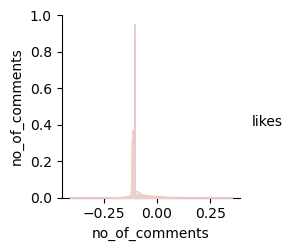

In [22]:
#count no_of_comments values greater than 5 compared to the total number of rows
print(train_df[train_df['no_of_comments'] > 5].shape[0] / train_df.shape[0])
print(val_df[val_df['no_of_comments'] > 5].shape[0] / val_df.shape[0])
print(test_df[test_df['no_of_comments'] > 5].shape[0] / test_df.shape[0])


#remove data points with no_of_comments for values greater than 5
train_df = train_df[train_df['no_of_comments'] <= 5]
val_df = val_df[val_df['no_of_comments'] <= 5]

# Pairplot scatter plot with hue for the target column
import seaborn as sns
sns.pairplot(train_df, y_vars=NUMERIC_COLS, x_vars=NUMERIC_COLS, hue=TARGET_COL)
plt.show()


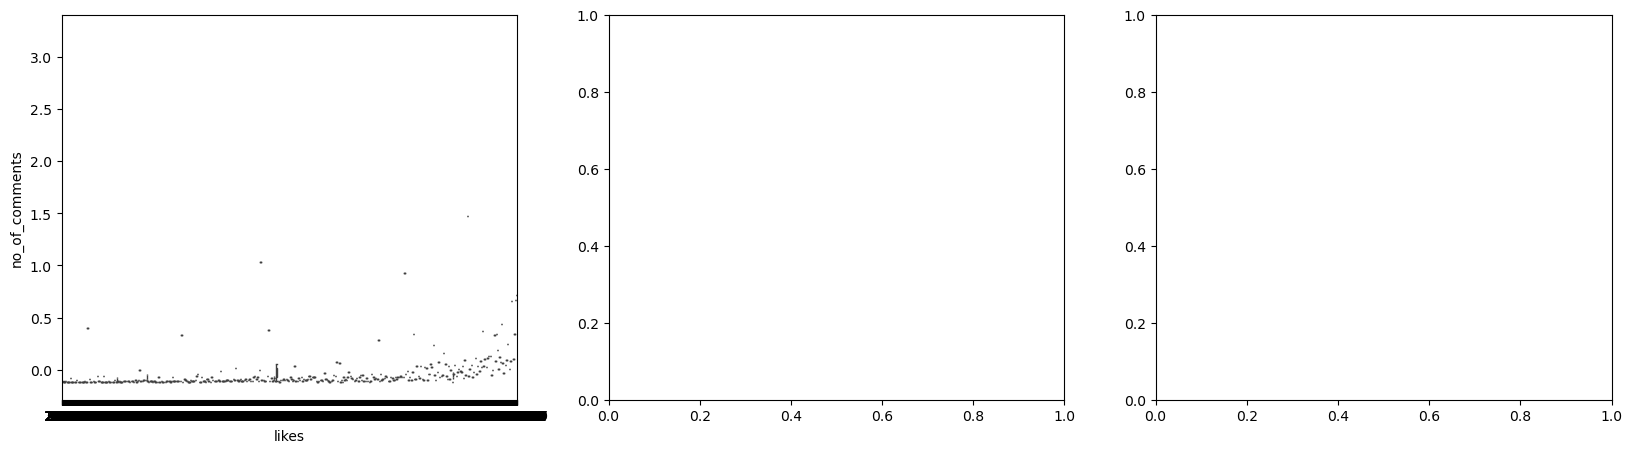

In [23]:
# Box plot each numeric feature with the target column
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for i, col in enumerate(NUMERIC_COLS):
    sns.boxplot(x=TARGET_COL, y=col, data=train_df, ax=axes[i])
plt.show()

In [24]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size, img_size, shuffle_data=True):
        self.df = df
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle_data = shuffle_data
        self.on_epoch_end()
        self.index = 0

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        # Shuffle data after each epoch
        if self.shuffle_data:
            self.df  = self.df.sample(frac=1).reset_index(drop=True)

    def __getitem__(self, index):
        # Get a batch of data based on the index
        batch_data = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size]
        
        images = []
        numerical_features = []
        labels = []

        for _, row in batch_data.iterrows():
            # Load and preprocess the image
            img_path = row[IMAGE_COL]
            image = cv2.imread(img_path)
            image = cv2.resize(image, self.img_size)

            # Normalize the image (scale pixel values to [0, 1])
            image = image / 255.0
            images.append(image)
            
            # Extract numerical features and label
            numerical_feature = row[NUMERIC_COLS].values
            label = row[TARGET_COL]

            numerical_features.append(numerical_feature)
            labels.append(label)

        # Convert lists to numpy arrays
        images = np.array(images)
        numerical_features = np.array(numerical_features)
        labels = np.array(labels)

        # Convert to tensors
        images = tf.convert_to_tensor(images, dtype=tf.float32)
        numerical_features = tf.convert_to_tensor(numerical_features, dtype=tf.float32)
        labels = tf.convert_to_tensor(labels, dtype=tf.float32)

        # Return the batch: both image and numerical features as inputs, labels as output
        return [images, numerical_features], labels

    
    def __iter__(self):
        """ Return the generator itself as an iterator. """
        self.index = 0  # Reset index when a new iterator is created
        return self

    def __next__(self):
        """ Yield the next batch or raise StopIteration if at the end. """
        if self.index < self.__len__():
            batch = self.__getitem__(self.index)
            self.index += 1
            return batch
        else:
            self.on_epoch_end()  # Shuffle and reset for the next epoch
            raise StopIteration

## Model

In [25]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [26]:
def build_DenseNet_model():

    backbone_model = MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_tensor=tf.keras.layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
    )

    pooling  = tf.keras.layers.GlobalMaxPooling2D()(backbone_model.output)
    
    dense = tf.keras.layers.Dense(units = 1024, kernel_regularizer= tf.keras.regularizers.l2(0.0001))(pooling)
    batch_norm = tf.keras.layers.BatchNormalization()(dense)
    leaky_relu = tf.keras.layers.LeakyReLU()(batch_norm)

    # concatenate the output of the backbone and the numerical features
    numerical_features_input = tf.keras.layers.Input(shape=(len(NUMERIC_COLS),))
    concat = tf.keras.layers.Concatenate()([leaky_relu, numerical_features_input])

    # Add a dense layer with 512 units
    dense = tf.keras.layers.Dense(units = 512, kernel_regularizer= tf.keras.regularizers.l2(0.0001))(concat)
    batch_norm = tf.keras.layers.BatchNormalization()(dense)
    leaky_relu = tf.keras.layers.LeakyReLU()(batch_norm)

    # Add a dense layer with 256 units
    dense = tf.keras.layers.Dense(units = 256, kernel_regularizer= tf.keras.regularizers.l2(0.0001))(leaky_relu)
    batch_norm = tf.keras.layers.BatchNormalization()(dense)
    leaky_relu = tf.keras.layers.LeakyReLU()(batch_norm)

    # Add a dense layer with 128 units
    dense = tf.keras.layers.Dense(units = 128, kernel_regularizer= tf.keras.regularizers.l2(0.0001))(leaky_relu)
    batch_norm = tf.keras.layers.BatchNormalization()(dense)
    leaky_relu = tf.keras.layers.LeakyReLU()(batch_norm)
    
    # Add the output layer with regression output
    regressor = tf.keras.layers.Dense(units = 1)(leaky_relu)
    
    model = tf.keras.models.Model(inputs = [backbone_model.input, numerical_features_input], outputs = regressor)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer,loss='mean_squared_error')
    return model

In [27]:
model = build_DenseNet_model()

In [28]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [29]:
training_generator = CustomDataGenerator(train_df, BATCH_SIZE, (IMG_SIZE, IMG_SIZE))
validation_generator = CustomDataGenerator(val_df, BATCH_SIZE, (IMG_SIZE, IMG_SIZE))
testing_generator = CustomDataGenerator(test_df, BATCH_SIZE, (IMG_SIZE, IMG_SIZE))

## Train model

In [30]:
EPOCHS = 50

In [31]:
earlystop = tf.keras.callbacks.EarlyStopping(patience=10)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=1e-6)
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/{epoch:02d}_{val_loss:.3f}_mobilenetv2_2.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
mycallbacks = [earlystop, learning_rate_reduction,checkpoint]

In [32]:
history = model.fit(training_generator, validation_data=validation_generator, epochs=EPOCHS, callbacks=mycallbacks)

Epoch 1/50


c:\Users\adish\anaconda3\envs\insta_posts\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


604/604 [==============================] - ETA: 0s - loss: 74068090880.0000

c:\Users\adish\anaconda3\envs\insta_posts\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(



Epoch 1: val_loss improved from inf to 62274375680.00000, saving model to models\01_62274375680.000_mobilenetv2_2.h5
604/604 [==============================] - 143s 237ms/step - loss: 74068090880.0000 - val_loss: 62274375680.0000 - lr: 0.0010
Epoch 2/50
604/604 [==============================] - ETA: 0s - loss: 74021052416.0000
Epoch 2: val_loss did not improve from 62274375680.00000
604/604 [==============================] - 143s 236ms/step - loss: 74021052416.0000 - val_loss: 62419169280.0000 - lr: 0.0010
Epoch 3/50
604/604 [==============================] - ETA: 0s - loss: 73908944896.0000
Epoch 3: val_loss improved from 62274375680.00000 to 62059794432.00000, saving model to models\03_62059794432.000_mobilenetv2_2.h5
604/604 [==============================] - 143s 236ms/step - loss: 73908944896.0000 - val_loss: 62059794432.0000 - lr: 0.0010
Epoch 4/50
 43/604 [=>............................] - ETA: 2:02 - loss: 107072438272.0000

KeyboardInterrupt: 

In [147]:
# Load the best model
model.load_weights('models/{epoch:02d}_{val_loss:.3f}_mobilenetv2.h5')

In [148]:
# Evaluate the model on the test set
test_loss = model.evaluate(testing_generator)
print(f"Test loss: {test_loss}")

c:\Users\adish\anaconda3\envs\insta_posts\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


48/48 [==============================] - 19s 381ms/step - loss: 72918458368.0000
Test loss: 72918458368.0


In [17]:
# Predict for 10 samples from the test set
for i in range(10):
    (image, numerical_features), label = testing_generator[i]
    prediction = model.predict([image, numerical_features])
    print(f"Predicted: {prediction[0][0]}, Actual: {label[0]}")

c:\Users\adish\anaconda3\envs\insta_posts\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 162ms/step
Predicted: 1857.75830078125, Actual: 316955.0


c:\Users\adish\anaconda3\envs\insta_posts\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 173ms/step
Predicted: 2290.375732421875, Actual: 158069.0
1/1 [==============================] - ETA: 0s

c:\Users\adish\anaconda3\envs\insta_posts\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 161ms/step
Predicted: 1856.336181640625, Actual: 28517.0


c:\Users\adish\anaconda3\envs\insta_posts\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 261ms/step
Predicted: 1907.201904296875, Actual: 550858.0
1/1 [==============================] - 0s 140ms/step


c:\Users\adish\anaconda3\envs\insta_posts\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Predicted: 1928.730712890625, Actual: 5143.0
1/1 [==============================] - ETA: 0s

c:\Users\adish\anaconda3\envs\insta_posts\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 161ms/step
Predicted: 2586.1103515625, Actual: 331993.0


c:\Users\adish\anaconda3\envs\insta_posts\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 176ms/step
Predicted: 1867.0684814453125, Actual: 158352.0


c:\Users\adish\anaconda3\envs\insta_posts\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 220ms/step
Predicted: 1937.533203125, Actual: 36315.0
1/1 [==============================] - ETA: 0s

c:\Users\adish\anaconda3\envs\insta_posts\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 153ms/step
Predicted: 2099.854248046875, Actual: 23458.0
1/1 [==============================] - ETA: 0s

c:\Users\adish\anaconda3\envs\insta_posts\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 166ms/step
Predicted: 1849.589111328125, Actual: 395520.0


In [134]:
# Fit linear regression model

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Extract the features and target
X_train = train_df[NUMERIC_COLS].values
y_train = train_df[TARGET_COL].values

X_val = val_df[NUMERIC_COLS].values
y_val = val_df[TARGET_COL].values

X_test = test_df[NUMERIC_COLS].values
y_test = test_df[TARGET_COL].values

# normalize the numerical featues
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Initialize the model
linear_model = LinearRegression()

# Fit the model
linear_model.fit(X_train, y_train)

# Predict on the validation set
val_predictions = linear_model.predict(X_val)

# Calculate the mean squared error
val_mse = mean_squared_error(y_val, val_predictions)
print(f"Validation MSE: {val_mse}")

# Predict on the test set
test_predictions = linear_model.predict(X_test)

# Calculate the mean squared error
test_mse = mean_squared_error(y_test, test_predictions)
print(f"Test MSE: {test_mse}")

Validation MSE: 27267486224.826675
Test MSE: 25057059084.533108


In [131]:
#Regression with svm
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Extract the features and target
X_train = train_df[["t_zeroed", "follower_count_at_t"]].values
y_train = train_df[TARGET_COL].values

X_val = val_df[["t_zeroed", "follower_count_at_t"]].values
y_val = val_df[TARGET_COL].values

X_test = test_df[["t_zeroed", "follower_count_at_t"]].values
y_test = test_df[TARGET_COL].values

# Initialize the model
svm_regressor = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Fit the model
svm_regressor.fit(X_train, y_train)

# Predict on the validation set
val_predictions = svm_regressor.predict(X_val)

# Calculate the mean squared error
val_mse = mean_squared_error(y_val, val_predictions)
print(f"Validation MSE: {val_mse}")

# Predict on the test set

test_predictions = svm_regressor.predict(X_test)

# Calculate the mean squared error
test_mse = mean_squared_error(y_test, test_predictions)
print(f"Test MSE: {test_mse}")

Validation MSE: 40285869018.06059
Test MSE: 42384028294.353195


In [112]:
# Predict for 100 samples from the test set
for i in range(100):
    print(f"Predicted: {test_predictions[i]}, Actual: {y_test[i]}")

Predicted: 151178.5392477237, Actual: 157225
Predicted: 181547.42363162967, Actual: 67504
Predicted: 129451.69908666896, Actual: 67472
Predicted: 136909.86196693344, Actual: 86959
Predicted: 274970.2511490085, Actual: 404232
Predicted: 202924.39523805515, Actual: 52825
Predicted: 147260.6307451338, Actual: 289501
Predicted: 130775.9442872191, Actual: 43194
Predicted: 140453.62518467827, Actual: 144255
Predicted: 215847.52078334516, Actual: 545221
Predicted: 142017.36313804972, Actual: 175043
Predicted: 146536.12246215812, Actual: 103332
Predicted: 132850.7830591407, Actual: 189091
Predicted: 141345.4739271824, Actual: 153121
Predicted: 141312.77323114558, Actual: 152136
Predicted: 168573.91574436845, Actual: 19413
Predicted: 157858.98351232108, Actual: 132922
Predicted: 145733.66953406835, Actual: 7722
Predicted: 144188.6796669084, Actual: 248108
Predicted: 139788.99823439136, Actual: 103574
Predicted: 182271.62102746186, Actual: 57705
Predicted: 318092.56956363196, Actual: 404190
Pred

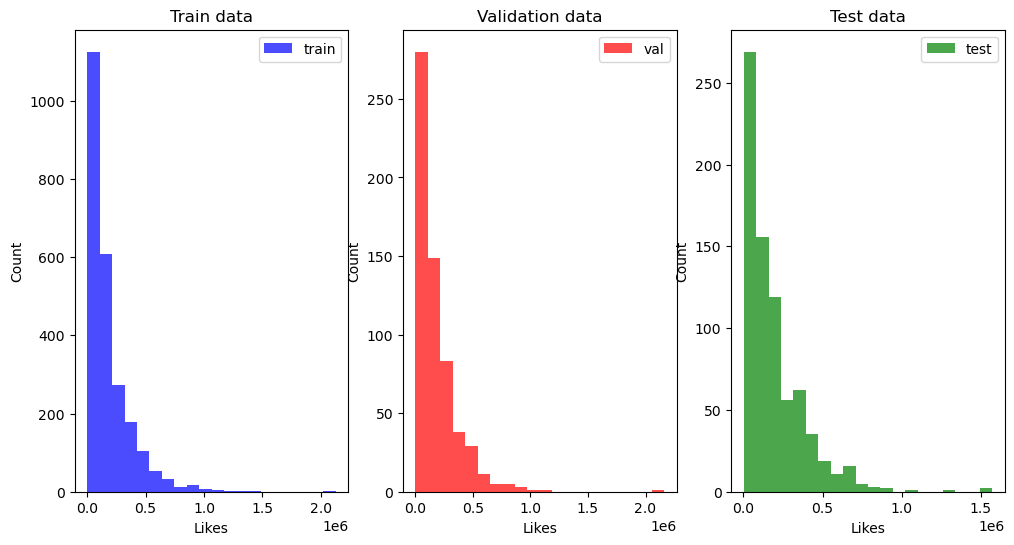

In [23]:
# Plot likes count in the three dataframes
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.hist(y_train, bins=20, color='blue', alpha=0.7, label='train')
plt.legend()
plt.xlabel('Likes')
plt.ylabel('Count')
plt.title('Train data')

plt.subplot(1, 3, 2)
plt.hist(y_val, bins=20, color='red', alpha=0.7, label='val')
plt.legend()
plt.xlabel('Likes')
plt.ylabel('Count')
plt.title('Validation data')

plt.subplot(1, 3, 3)
plt.hist(y_test, bins=20, color='green', alpha=0.7, label='test')
plt.legend()
plt.xlabel('Likes')
plt.ylabel('Count')
plt.title('Test data')

plt.show()

In [77]:
# Fit against only the number of comments

X_train = train_df[["follower_count_at_t"]].values
y_train = train_df[TARGET_COL].values

X_val = val_df[["follower_count_at_t"]].values
y_val = val_df[TARGET_COL].values

X_test = test_df[["follower_count_at_t"]].values
y_test = test_df[TARGET_COL].values

# Initialize the model
linear_model = LinearRegression()

# Fit the model
linear_model.fit(X_train, y_train)

# Predict on the validation set
val_predictions = linear_model.predict(X_val)

# Calculate the mean squared error
val_mse = mean_squared_error(y_val, val_predictions)
print(f"Validation MSE: {val_mse}")

# Predict on the test set
test_predictions = linear_model.predict(X_test)

# Calculate the mean squared error
test_mse = mean_squared_error(y_test, test_predictions)
print(f"Test MSE: {test_mse}")

Validation MSE: 35432611802.2118
Test MSE: 37138973615.04795


In [72]:
# Predict for 10 samples from the test set
for i in range(10):
    print(f"Predicted: {test_predictions[i]}, Actual: {y_test[i]}")
    

Predicted: 159094.76279844437, Actual: 157225
Predicted: 222832.90199455473, Actual: 67504
Predicted: 157099.42377423035, Actual: 67472
Predicted: 154146.10220997926, Actual: 86959
Predicted: 213154.24279190198, Actual: 404232
Predicted: 246084.11461127276, Actual: 52825
Predicted: 162175.82504513374, Actual: 289501
Predicted: 159094.76279844437, Actual: 43194
Predicted: 163786.22384305246, Actual: 144255
Predicted: 224151.50364118168, Actual: 545221


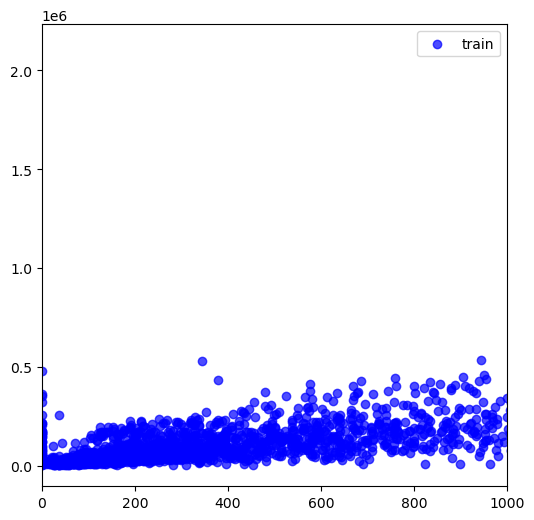

In [39]:
# Plot correlation between the number of comments and likes
plt.figure(figsize=(6, 6))
plt.xlim(0, 1000)
# plt.ylim(0, 100000)
plt.scatter(train_df["no_of_comments"], train_df["likes"], color='blue', alpha=0.7, label='train')
# plt.scatter(val_df["no_of_comments"], val_df["likes"], color='red', alpha=0.7, label='val')
# plt.scatter(test_df["no_of_comments"], test_df["likes"], color='green', alpha=0.7, label='test')
plt.legend()